In [19]:
import pandas as pd
import mne
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import matplotlib.pyplot as plt
import os
from datetime import datetime


The time duration of the data is 293 seconds
0        1.0
1        2.0
2        3.0
3        4.0
4        5.0
       ...  
288    289.0
289    290.0
290    291.0
291    292.0
292    293.0
Length: 293, dtype: float64


<Axes: >

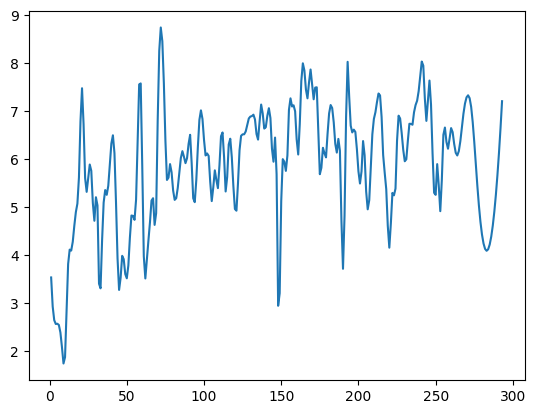

In [29]:
def extract_vo2_data(file_path, start_row=147, time_col='J', vo2_col='K'):
    df = pd.read_excel(file_path, skiprows=147)

    time = df.iloc[:, 9].tolist()
    vo2 = df.iloc[:, 10].tolist()
    return pd.DataFrame({'Time': time, 'VO2': vo2})

def extract_mc_data_csv(file_path):
    def time_to_seconds(time_str):
        try:
            minutes, seconds = map(int, time_str.split(":"))
            return minutes * 60 + seconds
        except:
            return None
    df = pd.read_csv(file_path)
    df["seconds"] = df["t"].apply(time_to_seconds)
    df['t'] = df['seconds']
    df = df.drop('seconds', axis=1)
    time_duration = df['t'].max()
    return df, time_duration


dir_vo2 = r"C:\Users\jirui\Documents\eeg_dataset\Pilot4_data\Metabolics"
path_vo2 = os.path.join(dir_vo2, "pilot4Oct_OG_A.csv")

mc_data, time_duration = extract_mc_data_csv(path_vo2)
mc_data.head()
print(f"The time duration of the data is {time_duration} seconds")


def interpolate_vo2_data(vo2_df, new_length):    
    vo2_df = vo2_df.copy()
    
    # Create a new index directly from the original time values
    min_time = int(vo2_df['t'].min())
    max_time = int(vo2_df['t'].max())
    # new_index = pd.Series(range(min_time, max_time + 1))
    new_index = pd.Series(np.linspace(min_time, max_time, new_length))
    print(new_index)
    
    # Create a new DataFrame with the interpolated values
    new_df = pd.DataFrame({'t': new_index})
    new_df = new_df.merge(vo2_df, on='t', how='left')
    new_df['VO2'] = new_df["VO2(ml/min)"].interpolate(method='polynomial', order=3)
    new_df["VCO2"] = new_df["VCO2(ml/min)"].interpolate(method='polynomial', order=3)
    new_df["EEM"] = new_df["Eem(kcal/m)"].interpolate(method='polynomial', order=3)
    new_df["EEM_Norm"] = new_df["Eem_Norm"].interpolate(method='polynomial', order=3)
    
    return new_df

def interpolate_df_to_length(df, target_length):
    # Create new time index with desired length
    new_index = np.linspace(df['Time'].min(), df['Time'].max(), target_length)
    return df.reindex(index=new_index).interpolate(method='polynomial', order=5)

vo2_df_interpolated = interpolate_vo2_data(mc_data, 293)
eem = vo2_df_interpolated["EEM"].to_numpy()
idx = vo2_df_interpolated["t"].to_numpy()
sns.lineplot(x=idx, y=eem)


In [4]:
def read_bdf_file(file_path):
    raw = mne.io.read_raw_bdf(file_path, preload=True)
    return raw

dir_eeg = r"C:\Users\jirui\Documents\eeg_dataset\Pilot4_data\EEG"
path_eeg = os.path.join(dir_eeg, "Pilot4Oct_OG_A.bdf")
raw_data  = read_bdf_file(path_eeg)
raw_data.times[-1]

Extracting EDF parameters from C:\Users\jirui\Documents\eeg_dataset\Pilot4_data\EEG\Pilot4Oct_OG_A.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 155135  =      0.000 ...   302.998 secs...


302.998046875

In [5]:
sampling_frequecy = raw_data.info['sfreq']
samples_to_trim = int(10*sampling_frequecy)

# trim last 10 seconds
raw_data_trimmed = raw_data.copy().crop(tmin=raw_data.times[-1]-293)
print(f"New duration: {raw_data_trimmed.times[-1]} seconds")

raw_data_trimmed.get_data().shape

New duration: 293.0 seconds


(144, 150017)

In [13]:


# Interpolate the VO2 data
vo2_df_interpolated = interpolate_vo2_data(vo2_raw, 293)

vo2_array  = vo2_df_interpolated["EEM"].to_numpy()
vo2_array = vo2_array.reshape(1, -1)
print(f"The shape of the interpolated VO2 data is {vo2_array.shape}")

# print(f"Original length: {len(vo2_df)}")
# print(f"New length: {len(vo2_df_interpolated)}")
# print(f"Target length: {new_length}")

# fig, axes = plt.subplots(2, 1)
# # sns.lineplot(data=vo2_df_interpolated, x='Time', y='VO2', label='Interpolated')
# sns.scatterplot(data=vo2_raw, x='Time', y='VO2', color='red', label='Original', ax=axes[0], s=20)
# sns.scatterplot(data=vo2_df_interpolated, x='Time', y='VO2', label='Interpolated', ax=axes[1], s=20)
# plt.legend()
# plt.show()

# fig, axes = plt.subplots(2, 1)
# # sns.lineplot(data=vo2_df_interpolated, x='Time', y='VO2', label='Interpolated')
# sns.lineplot(data=vo2_raw, x='Time', y='VO2', color='red', label='Original', ax=axes[0])
# sns.lineplot(data=vo2_df_interpolated, x='Time', y='VO2', label='Interpolated', ax=axes[1])
# plt.legend()
# plt.show()


TypeError: '<=' not supported between instances of 'str' and 'float'

<Axes: xlabel='Time', ylabel='VO2'>

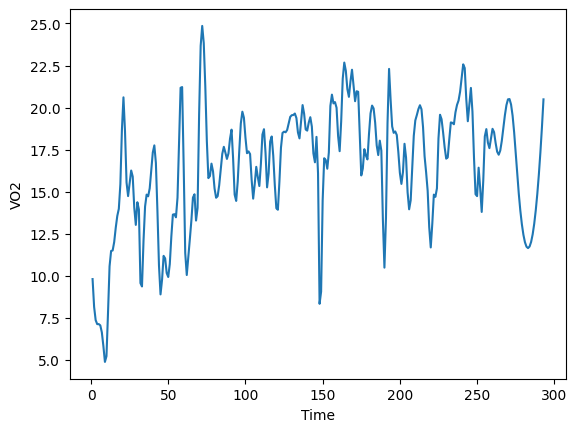

In [9]:
vo2_df_interpolated
sns.lineplot(data=vo2_df_interpolated, x='Time', y='VO2')


<Axes: >

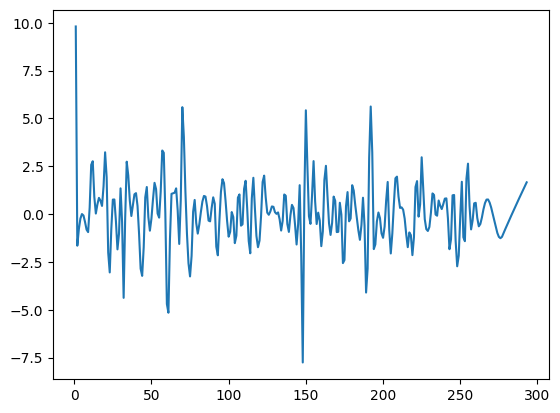

In [10]:
VO2 = vo2_df_interpolated['VO2'].to_numpy()
vo2_idx = vo2_df_interpolated['Time'].to_numpy()
diff = np.diff(VO2)
inserted_result = np.insert(diff, 0, VO2[0])
sns.lineplot(x=vo2_idx, y=inserted_result)


In [18]:
def align_vo2_with_eeg(vo2_df, eeg_raw):
    # Calculate the number of EEG samples per second
    sfreq = eeg_raw.info['sfreq']
    samples_per_second = int(sfreq)

    eeg_data = eeg_raw.get_data()
    X = []
    y = []

    for i in range(len(vo2_df)):
        start_time = vo2_df['Time'].iloc[i]
        start_sample = int(start_time * sfreq)
        end_sample = start_sample + samples_per_second

        if end_sample > eeg_data.shape[1]:
            break

        eeg_segment = eeg_data[:, start_sample:end_sample]
        vo2_value = vo2_df['VO2'].iloc[i]

        X.append(eeg_segment)
        y.append(vo2_value)

    X = np.array(X)
    y = np.array(y)

    return X, y

# Assuming vo2_df_interpolated is the interpolated VO2 data
X, y = align_vo2_with_eeg(vo2_df_interpolated, raw_data)

In [19]:
import torch
from torch import nn
from torch.nn import MaxPool1d

class MODCNN_1D_MUST(nn.Module):
    def __init__(self, numChannels, numNodes=[128, 128, 128, 64, 256]):
        """
        :param numChannels:
        :param classes:
        :param numNodes: number of nodes in hidden layer
        Structure of CNN: CONV1 => RELU => CONV2 => RELU => POOLING => DROPOUT
        """
        # Call the parent constructor
        super(MODCNN_1D_MUST, self).__init__()
        # self.classes = classes
        self.channels = numChannels

        conv1 = torch.nn.Conv1d(in_channels=numChannels, out_channels=numNodes[0], kernel_size=3)
        relu1 = torch.nn.ReLU()
        conv2 = torch.nn.Conv1d(in_channels=numNodes[0], out_channels=numNodes[1], kernel_size=3)
        relu2 = torch.nn.ReLU()
        maxpool2 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        dropout2 = nn.Dropout(p=0.5)
        self.cnnBlock1 = nn.Sequential(conv1, relu1, conv2, relu2, maxpool2, dropout2)

        # initialize second set of CNN
        conv3 = torch.nn.Conv1d(in_channels=numNodes[1], out_channels=numNodes[2], kernel_size=3)
        relu3 = torch.nn.ReLU()
        conv4 = torch.nn.Conv1d(in_channels=numNodes[2], out_channels=numNodes[3], kernel_size=3)
        relu4 = torch.nn.ReLU()
        maxpool4 = MaxPool1d(kernel_size=2, stride=2)
        dropout4 = nn.Dropout(p=0.5)
        self.cnnBlock2 = nn.Sequential(conv3, relu3, conv4, relu4, maxpool4, dropout4)

        # Calculate the size of the flattened feature map
        self._to_linear = None
        self.convs(torch.randn(1, numChannels, 512))

        # Regression output
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self._to_linear, numNodes[4]),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(numNodes[4], 1)
        )

    def convs(self, x):
        x = self.cnnBlock1(x)
        x = self.cnnBlock2(x)
        if self._to_linear is None:
            self._to_linear = x.shape[1] * x.shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = self.regressor(x)
        return x


In [20]:
from NMI.nmi_1d_v2 import Trainer1DCNN

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

channels = raw_data.get_data().shape[0]


model = MODCNN_1D_MUST(numChannels=channels, numNodes=[128, 128, 128, 64, 256])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()


trainer = Trainer1DCNN(device=device, model=model, x_data=X, y_data=y, optimizer=optimizer, criterion=criterion)

model_ret, trained_model = trainer(epoches=500)


Number of train batch: 4; train batch size is: 64
Number of val batch: 1; val batch size is: 64
Epoch 1/500, Training Loss: 3409708.2422, Validation Loss: 544.3881, MAE: 23.0226, MSE: 544.3881
Epoch 2/500, Training Loss: 8076.5914, Validation Loss: 268.5734, MAE: 15.9443, MSE: 268.5734
Epoch 3/500, Training Loss: 267.8527, Validation Loss: 268.5280, MAE: 15.9429, MSE: 268.5280
Epoch 4/500, Training Loss: 170.2928, Validation Loss: 268.4959, MAE: 15.9419, MSE: 268.4959
Epoch 5/500, Training Loss: 156.4134, Validation Loss: 268.4715, MAE: 15.9411, MSE: 268.4715
Epoch 6/500, Training Loss: 171.5136, Validation Loss: 268.4456, MAE: 15.9403, MSE: 268.4456
Epoch 7/500, Training Loss: 143.1273, Validation Loss: 268.4253, MAE: 15.9396, MSE: 268.4253
Epoch 8/500, Training Loss: 136.1978, Validation Loss: 268.4029, MAE: 15.9389, MSE: 268.4029
Epoch 9/500, Training Loss: 149.3658, Validation Loss: 268.3827, MAE: 15.9383, MSE: 268.3827
Epoch 10/500, Training Loss: 125.6496, Validation Loss: 268.36

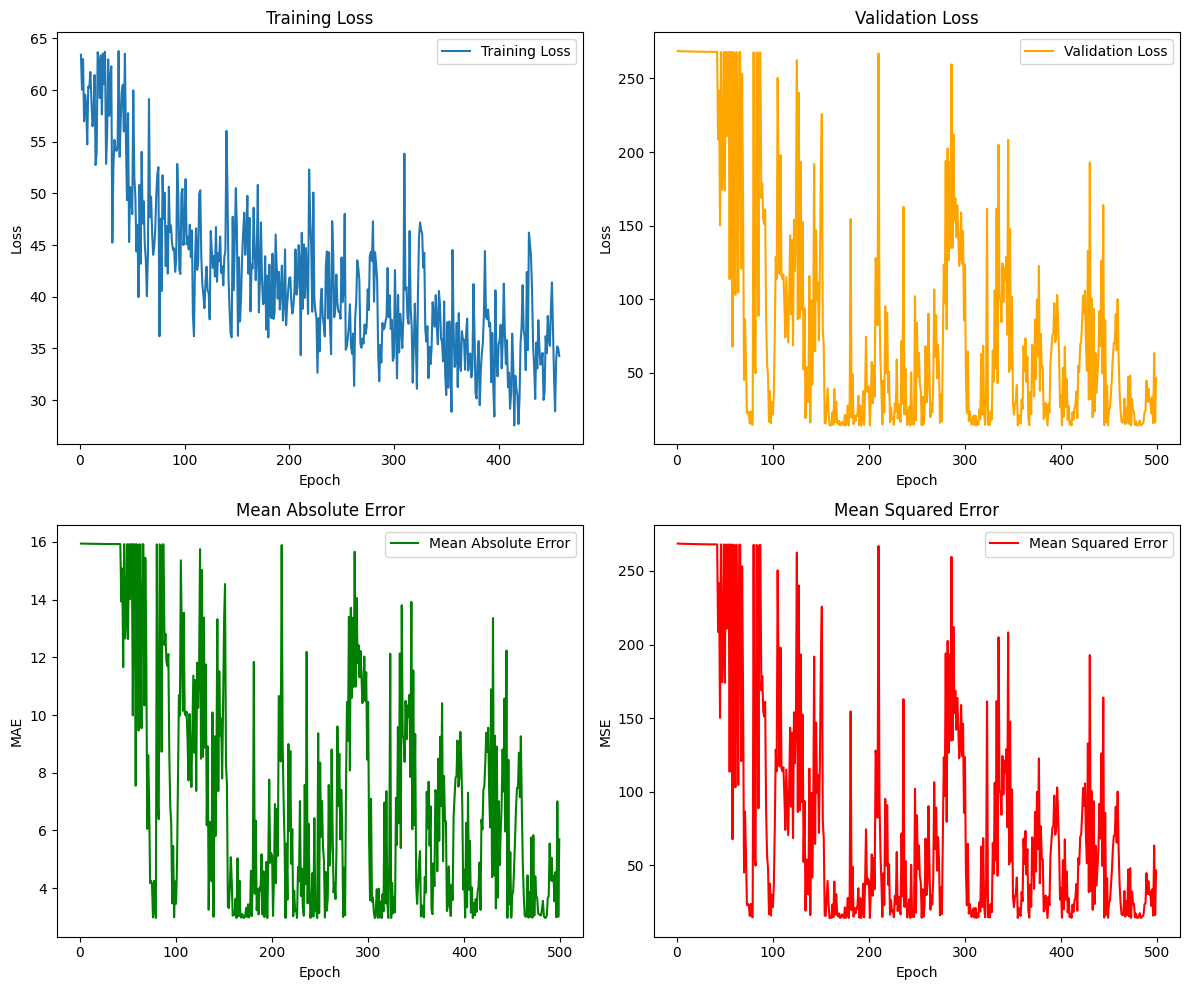

In [21]:
import matplotlib.pyplot as plt

def remove_outliers(data):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Remove outliers
    filtered_data = [x for x in data if lower_bound <= x <= upper_bound]
    return filtered_data

def plot_metrics(model_ret):
    epochs = model_ret['epoch']
    
    # Remove outliers from each metric
    train_loss = remove_outliers(model_ret['train_loss'])
    val_loss = remove_outliers(model_ret['val_loss'])
    mae = remove_outliers(model_ret['mae'])
    mse = remove_outliers(model_ret['mse'])
    
    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Plot training loss
    axs[0, 0].plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
    axs[0, 0].set_title('Training Loss')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].set_ylabel('Loss')
    axs[0, 0].legend()
    
    # Plot validation loss
    axs[0, 1].plot(epochs[:len(val_loss)], val_loss, label='Validation Loss', color='orange')
    axs[0, 1].set_title('Validation Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].legend()
    
    # Plot MAE
    axs[1, 0].plot(epochs[:len(mae)], mae, label='Mean Absolute Error', color='green')
    axs[1, 0].set_title('Mean Absolute Error')
    axs[1, 0].set_xlabel('Epoch')
    axs[1, 0].set_ylabel('MAE')
    axs[1, 0].legend()
    
    # Plot MSE
    axs[1, 1].plot(epochs[:len(mse)], mse, label='Mean Squared Error', color='red')
    axs[1, 1].set_title('Mean Squared Error')
    axs[1, 1].set_xlabel('Epoch')
    axs[1, 1].set_ylabel('MSE')
    axs[1, 1].legend()
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

plot_metrics(model_ret)

In [15]:
def test_fun(a=1, b=2):
    def inner_fun():
        return a+b
    return inner_fun()


a = test_fun()
print(a)



3


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

def read_txt_data(file_path, column_names=None, separator='\s+', skip_rows=0, encoding='utf-8'):
    """
    Read data from a txt file into a pandas DataFrame.
    
    Parameters:
    -----------
    file_path : str
        Path to the txt file
    column_names : list, optional
        List of column names. If None, will use default numbered columns
    separator : str, default '\s+'
        Delimiter to use. '\s+' means any whitespace
    skip_rows : int, default 0
        Number of rows to skip at the beginning of the file
    encoding : str, default 'utf-8'
        File encoding to use
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the data from the txt file
    """
    try:
        # Read the file into a DataFrame
        df = pd.read_csv(
            file_path,
            sep=separator,
            names=column_names,
            skiprows=skip_rows,
            encoding=encoding
        )
        
        # Print basic information about the loaded data
        print(f"Data loaded successfully!")
        print(f"Shape: {df.shape}")
        print("\nFirst few rows:")
        print(df.head())
        
        return df
        
    except FileNotFoundError:
        print(f"Error: File '{file_path}' not found")
    except Exception as e:
        print(f"Error loading file: {str(e)}")


data_path = r"D:\EEG_WalkSpeed_Dataset\Ll01\D-Flow\Ll01_level_selfpaced_treadmill0001.txt"
column_names = ["Time", "Left_VT", "Right_VT", "Pitch", "Pitch_VGait"]
data = read_txt_data(data_path, column_names=column_names, skip_rows=1)


<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\jirui\AppData\Local\Temp\ipykernel_26808\1126105256.py:5: SyntaxWarning: invalid escape sequence '\s'
  def read_txt_data(file_path, column_names=None, separator='\s+', skip_rows=0, encoding='utf-8'):
C:\Users\jirui\AppData\Local\Temp\ipykernel_26808\1126105256.py:6: SyntaxWarning: invalid escape sequence '\s'
  """


Error: File 'D:\EEG_WalkSpeed_Dataset\Ll01\D-Flow\Ll01_level_selfpaced_treadmill0001' not found
